In [ ]:
import os
import sys

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from typing import Tuple, List, Dict, Optional, Union, Iterable
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

device = "cuda" if torch.cuda.is_available else "cpu"

SEED = 2022

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = r"/content/drive/MyDrive/ML_Indastry/data"

### Early fusion multimodal MLP

In [ ]:
class TopAccuracy(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x, ground_truth):

        x_norm = torch.sigmoid(x)
        x_norm_max = x_norm.max(1)

        pred_lab = x_norm_max.values.detach().cpu()
        true_lab = ground_truth[[i for i in range(ground_truth.shape[0])], list(x_norm_max.indices.detach().cpu().numpy())].detach().cpu()

        accuracy = (pred_lab.round() == true_lab).sum() / pred_lab.shape[0]

        return accuracy

In [ ]:
class MultiModalData(Dataset):
    def __init__(self, genres, images, texts):
        super().__init__()
        assert genres.shape[0] == images.shape[0] and images.shape[0] == texts.shape[0]

        self.genres = genres
        self.images = images
        self.texts = texts

        self.len = genres.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (self.genres[idx], self.images[idx], self.texts[idx])

In [ ]:
class MultiModal_E(nn.Module):

    def __init__(
        self, 
        image_input: int,
        text_input: int,
        output: int
    ):
        super().__init__()

        self.text_model = nn.Sequential(*[nn.Linear(text_input, 512), 
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5),
                                          ]
        )

        self.image_model = nn.Sequential(*[nn.Linear(image_input, 512), 
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5),
                                          ]
        )

        self.classifier = nn.Sequential(*[nn.Linear(1024, 256), 
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5),
                                          nn.Linear(256, 128), 
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5),
                                          nn.Linear(128, output), 
                                          ]
        )

    def forward(self, image, text):

        text_vector = self.text_model(text)
        image_vector = self.image_model(image)

        cat_vactor = torch.cat([text_vector, image_vector], dim=1)
        out = self.classifier(cat_vactor)
        return out

    def train_model(self, optimizer, train_loader, eval_loader, nepoch, device, plot=True):

        self.to(device)

        fn_loss = nn.BCEWithLogitsLoss().to(device)
        loss_list = []

        vall_loss_list = []
        vall_acc_list = []
        with torch.enable_grad():
            for epoch in tqdm(range(nepoch)):
                loss_val = 0.0
                self.train()
                for _, batch in enumerate(train_loader):
                    y, img, txt = batch
                    y, img, txt = y.to(device), img.to(device), txt.to(device)
                    out = self(img, txt)
                    loss = fn_loss(out, y)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    loss_val += loss.item()

                
                loss_list.append(loss_val/(_+1))
                if plot:
                    print(f"Epoch: {epoch} of {nepoch};")
                    print(f"Train loss: {loss_list[-1]};")

                val_error = self.eval_model(eval_loader, device, plot=plot)
                vall_loss_list.append(val_error[0])
                vall_acc_list.append(val_error[1])

                if plot:
                    print()

        return loss_list, vall_loss_list, vall_acc_list

    def eval_model(self, eval_loader, device, plot=True):

        loss_val = 0.0
        acc_val = 0.0

        fn_loss = nn.BCEWithLogitsLoss().to(device)
        t1_acc = TopAccuracy().to(device)

        self.eval()
        with torch.no_grad():
            for _, batch in enumerate(eval_loader):
                y, img, txt = batch
                y, img, txt = y.to(device), img.to(device), txt.to(device)
                out = self(img, txt)
                
                loss = fn_loss(out, y)
                acc = t1_acc(out, y)

                loss_val += loss.item()
                acc_val += acc.item()

            if plot:
                print(f"Val bce loss: {loss_val/(_+1  )}")
                print(f"Val mse loss: {acc_val/(_+1  )}")
            return loss_val/(_+1  ), acc_val/(_+1  )

In [ ]:
class MultiModal_L(nn.Module):

    def __init__(
        self, 
        image_input: int,
        text_input: int,
        output: int
    ):
        super().__init__()

        self.text_model = nn.Sequential(*[nn.Linear(text_input, 512), 
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5),
                                          nn.Linear(512, 256),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5), 
                                          nn.Linear(256, 128), 
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5), 
                                          nn.Linear(128, 64), 
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5), 
                                          ]
        )

        self.image_model = nn.Sequential(*[nn.Linear(image_input, 1024), 
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5),
                                           nn.Linear(1024, 256),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5), 
                                          nn.Linear(256, 128),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5), 
                                          nn.Linear(128, 64),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5), 
                                          ]
        )

        self.classifier = nn.Sequential(*[nn.Linear(128, output)]
        )

    def forward(self, image, text):

        text_vector = self.text_model(text)
        image_vector = self.image_model(image)

        cat_vactor = torch.cat([text_vector, image_vector], dim=1)
        out = self.classifier(cat_vactor)
        return out

    def train_model(self, optimizer, train_loader, eval_loader, nepoch, device, plot=True):

        self.to(device)

        fn_loss = nn.BCEWithLogitsLoss().to(device)
        loss_list = []

        vall_loss_list = []
        vall_acc_list = []
        with torch.enable_grad():
            for epoch in tqdm(range(nepoch)):
                loss_val = 0.0
                self.train()
                for _, batch in enumerate(train_loader):
                    y, img, txt = batch
                    y, img, txt = y.to(device), img.to(device), txt.to(device)
                    out = self(img, txt)
                    loss = fn_loss(out, y)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    loss_val += loss.item()

                
                loss_list.append(loss_val/(_+1))
                if plot:
                    print(f"Epoch: {epoch} of {nepoch};")
                    print(f"Train loss: {loss_list[-1]};")

                val_error = self.eval_model(eval_loader, device, plot=plot)
                vall_loss_list.append(val_error[0])
                vall_acc_list.append(val_error[1])

                if plot:
                    print()

        return loss_list, vall_loss_list, vall_acc_list

    def eval_model(self, eval_loader, device, plot=True):

        loss_val = 0.0
        acc_val = 0.0

        fn_loss = nn.BCEWithLogitsLoss().to(device)
        t1_acc = TopAccuracy().to(device)

        self.eval()
        with torch.no_grad():
            for _, batch in enumerate(eval_loader):
                y, img, txt = batch
                y, img, txt = y.to(device), img.to(device), txt.to(device)
                out = self(img, txt)
                
                loss = fn_loss(out, y)
                acc = t1_acc(out, y)

                loss_val += loss.item()
                acc_val += acc.item()

            if plot:
                print(f"Val bce loss: {loss_val/(_+1  )}")
                print(f"Val mse loss: {acc_val/(_+1  )}")
            return loss_val/(_+1  ), acc_val/(_+1  )

### Preparing base dataset (ids and genres)

In [ ]:
files = os.listdir(data_path)
files

['movie_info_final.csv', 'text_encoded', 'image_encoded']

In [ ]:
df = pd.read_csv(os.path.join(data_path, files[0]))

In [ ]:
df

,index,imdb_id,title,plot,genres
0,0,4179452,The Last Kingdom,"In the year 872, many of the separate kingdoms...","['Action', 'Drama', 'History']"
1,1,3748528,Rogue One,All looks lost for the Rebellion against the E...,"['Action', 'Adventure', 'Sci-Fi']"
2,2,5626028,Boku no hîrô akademia,"In a world populated with superhumans, the sup...","['Animation', 'Action', 'Adventure', 'Fantasy'..."
3,3,3322312,Daredevil,As a child Matt Murdock was blinded by a chemi...,"['Action', 'Crime', 'Drama', 'Fantasy', 'Sci-F..."
4,4,2580046,Miraculous: Tales of Ladybug & Cat Noir,"By daylight, Marinette Dupain-Cheng and Adrien...","['Animation', 'Action', 'Adventure', 'Family',..."
...,...,...,...,...,...
3498,207,1385817,Anyone But Me,When 16 year old Vivian McMillan has to move f...,"['Short', 'Comedy', 'Drama']"
3499,208,1253563,Smáfuglar,2 Birds takes place during one bright summer n...,"['Short', 'Drama']"
3500,211,1255891,Next Floor,"Around a long and ponderous dining table, befo...","['Short', 'Comedy']"
3501,212,1295053,AM1200,Cocky investment analyst Sam Larson (raised in...,"['Short', 'Horror']"


In [ ]:
from ast import literal_eval


all_genres = []
df_genres = df.genres.tolist()
for _, i in tqdm(enumerate(df_genres)):
    i = literal_eval(i)
    all_genres.extend(i)
    if _ % 100 == 0:
        all_genres = list(set(all_genres))

all_genres = sorted(list(set(all_genres)))

0it [00:00, ?it/s]

In [ ]:
def genres_to_vector(x):
    x_arr = literal_eval(x)
    result = np.zeros(len(all_genres), dtype=object)
    for _, i in enumerate(all_genres):
        if i in x_arr:
            result[_] = 1
        else:
            result[_] = 0
    return result

In [ ]:
genres_to_vector_v = np.vectorize(lambda x: genres_to_vector(x))
genres_vectors = np.array([np.asarray(i, dtype=float) for i in genres_to_vector_v(df.genres)])

In [ ]:
df = df.drop(["genres", "title", "plot", "index"], axis=1)
df_genres = pd.DataFrame(genres_vectors, columns=[f"genre_{i}" for i in range(genres_vectors.shape[1])])
df = pd.concat([df, df_genres], axis=1)

df.head()

,imdb_id,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,...,genre_18,genre_19,genre_20,genre_21,genre_22,genre_23,genre_24,genre_25,genre_26,genre_27
0,4179452,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3748528,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5626028,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3322312,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2580046,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Several encoding model combination

In [ ]:
image_path = os.path.join(data_path, files[2])
text_path = os.path.join(data_path, files[1])

In [ ]:
image_files = os.listdir(image_path)
text_files = os.listdir(text_path)

In [ ]:
df_images = pd.DataFrame(image_files, columns={"image_encoded"})
df_images["_key"] = 1

df_texts = pd.DataFrame(text_files, columns={"text_encoded"})
df_texts["_key"] = 1

df_files = pd.merge(df_images, df_texts, on="_key").drop("_key", axis=1)
del df_images, df_texts

In [ ]:
df_files

,image_encoded,text_encoded
0,resnet.csv,plot_hidden_states_roberta.csv
1,resnet.csv,plot_hidden_states_xlnet.csv
2,resnet.csv,plot_hidden_states_distilbert_imdb.csv
3,resnet_dino.csv,plot_hidden_states_roberta.csv
4,resnet_dino.csv,plot_hidden_states_xlnet.csv
5,resnet_dino.csv,plot_hidden_states_distilbert_imdb.csv
6,resnet_dino_full.csv,plot_hidden_states_roberta.csv
7,resnet_dino_full.csv,plot_hidden_states_xlnet.csv
8,resnet_dino_full.csv,plot_hidden_states_distilbert_imdb.csv


### Models calculations (Early fusion)

In [ ]:
results = []
for idx in tqdm(range(df_files.shape[0])):

    img_file, txt_file = df_files.iloc[idx, 0], df_files.iloc[idx, 1]
    img_file, txt_file = os.path.join(image_path, img_file), os.path.join(text_path, txt_file)

    df_images, df_texts = pd.read_csv(img_file), pd.read_csv(txt_file, header=None)
    idx = list(set(df_images.movie_id.to_list()).intersection(set(df.imdb_id.to_list())))

    genres = df[df.imdb_id.isin(idx)]
    images = df_images[df_images.movie_id.isin(idx)]

    text = df_texts.copy()
    text["imdb_id"] = df.imdb_id
    text = text[text.imdb_id.isin(idx)]

    genres = genres.drop_duplicates(["imdb_id"]).sort_values("imdb_id").reset_index(drop=True)
    images = images.drop_duplicates(["movie_id"]).sort_values("movie_id").reset_index(drop=True)
    text = text.drop_duplicates(["imdb_id"]).sort_values("imdb_id").reset_index(drop=True)


    ### train/test split
    genres_train, genres_test, images_train, images_test, text_train, text_test  = train_test_split(genres, images, text, test_size=0.3, random_state=69)

    genres_train_t, images_train_t, text_train_t = torch.from_numpy(np.array(genres_train.iloc[:, 1:])).float(), torch.from_numpy(np.array(images_train.iloc[:, 1:])).float(), torch.from_numpy(np.array(text_train.iloc[:, :-1])).float()
    genres_test_t, images_test_t, text_test_t = torch.from_numpy(np.array(genres_test.iloc[:, 1:])).float(), torch.from_numpy(np.array(images_test.iloc[:, 1:])).float(), torch.from_numpy(np.array(text_test.iloc[:, :-1])).float()

    ### datasets
    data_train = MultiModalData(genres_train_t, images_train_t, text_train_t)
    data_test = MultiModalData(genres_test_t, images_test_t, text_test_t)

    ### dataloaders
    loader_train = DataLoader(data_train, batch_size=32, shuffle=True)
    loader_test = DataLoader(data_test, batch_size=32, shuffle=False)

    model_e = MultiModal_E(2048, 768, 28)
    opt = torch.optim.Adam(model_e.parameters(), lr=0.001, betas=(0.85, 0.999))
    errors = model_e.train_model(opt, loader_train, loader_test, 100, device, plot=False)

    results.append(errors)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

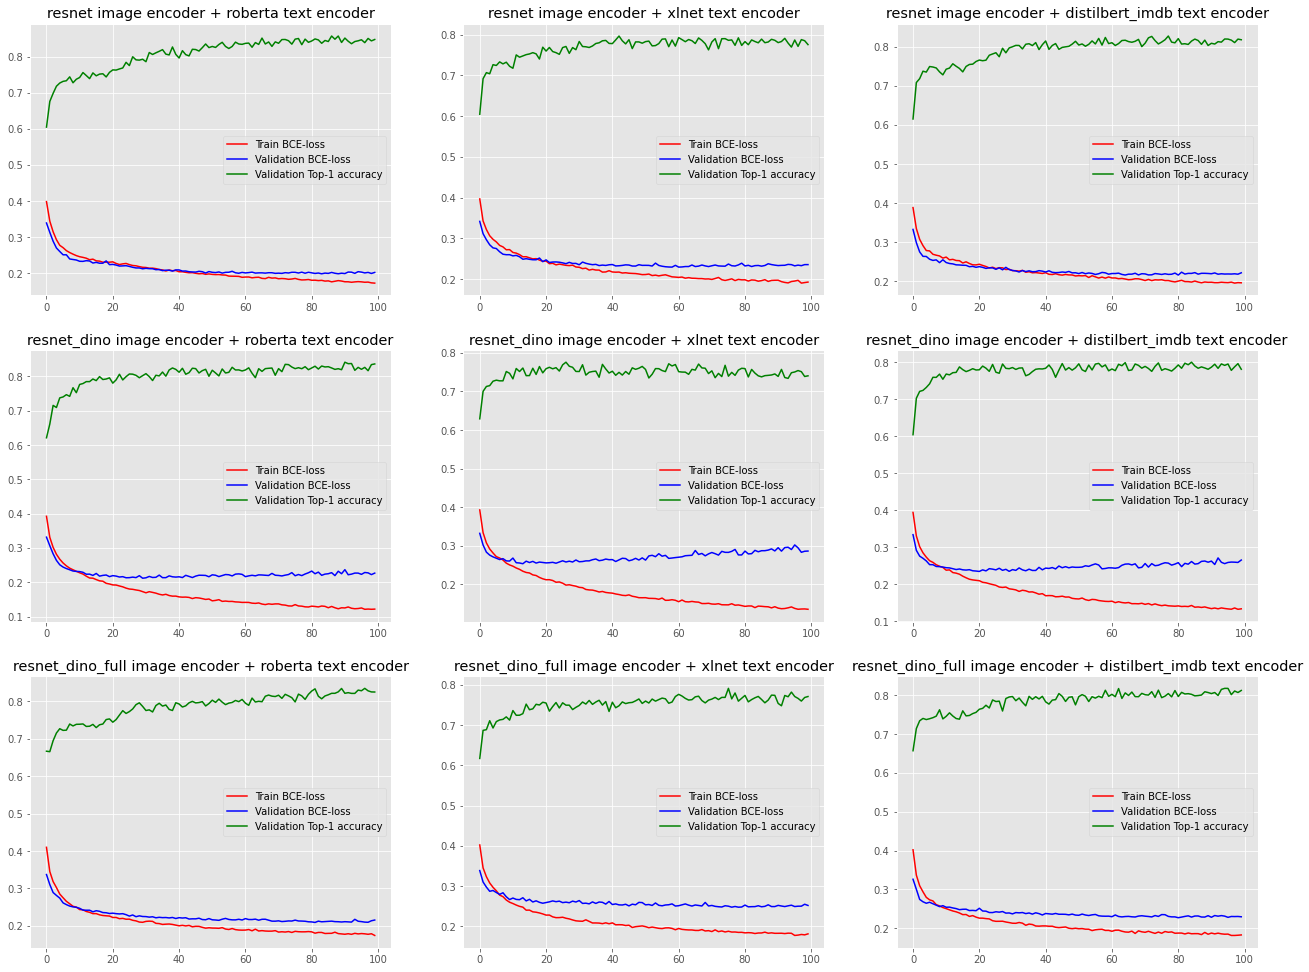

In [ ]:
plt.rcParams["figure.figsize"] = (22, 17)
plt.style.use('ggplot')
fig, ax = plt.subplots(3, 3)


img_name_list = []
txt_name_list = []
train_loss_list = []
val_loss_list = []
val_acc_list = []


for idx in range(9):
    img_file, txt_file = df_files.iloc[idx, 0][:-4], df_files.iloc[idx, 1][19:-4]
    x, y = idx // 3, idx % 3
    ax[x, y].plot(results[idx][0], label="Train BCE-loss", color="r")
    ax[x, y].plot(results[idx][1], label="Validation BCE-loss", color="b")
    ax[x, y].plot(results[idx][2], label="Validation Top-1 accuracy", color="g")

    ax[x, y].legend()
    ax[x, y].set_title(f"{img_file} image encoder + {txt_file} text encoder")

    img_name_list.append(img_file)
    txt_name_list.append(txt_file)
    train_loss_list.append(np.min(results[idx][0]))
    val_loss_list.append(np.min(results[idx][1]))
    val_acc_list.append(np.max(results[idx][2]))

fig.savefig(os.path.join(data_path, "result.png"), dpi=300)

In [ ]:
df_results = pd.DataFrame({"Image_encoder": img_name_list, "Text_encoder": txt_name_list, "Train_loss": train_loss_list, "Test_loss": val_loss_list, "Test_accuracy": val_acc_list})
df_results

,Image_encoder,Text_encoder,Train_loss,Test_loss,Test_accuracy
0,resnet,roberta,0.172557,0.198387,0.856879
1,resnet,xlnet,0.190036,0.229345,0.796549
2,resnet,distilbert_imdb,0.194939,0.215615,0.827799
3,resnet_dino,roberta,0.121053,0.211645,0.841688
4,resnet_dino,xlnet,0.134496,0.252793,0.776042
5,resnet_dino,distilbert_imdb,0.132925,0.235186,0.800456
6,resnet_dino_full,roberta,0.174604,0.209363,0.834418
7,resnet_dino_full,xlnet,0.177504,0.247729,0.791450
8,resnet_dino_full,distilbert_imdb,0.181284,0.226969,0.817817


### Models calculations (Late fusion)

In [ ]:
results = []
for idx in tqdm(range(df_files.shape[0])):

    img_file, txt_file = df_files.iloc[idx, 0], df_files.iloc[idx, 1]
    img_file, txt_file = os.path.join(image_path, img_file), os.path.join(text_path, txt_file)

    df_images, df_texts = pd.read_csv(img_file), pd.read_csv(txt_file, header=None)
    idx = list(set(df_images.movie_id.to_list()).intersection(set(df.imdb_id.to_list())))

    genres = df[df.imdb_id.isin(idx)]
    images = df_images[df_images.movie_id.isin(idx)]

    text = df_texts.copy()
    text["imdb_id"] = df.imdb_id
    text = text[text.imdb_id.isin(idx)]

    genres = genres.drop_duplicates(["imdb_id"]).sort_values("imdb_id").reset_index(drop=True)
    images = images.drop_duplicates(["movie_id"]).sort_values("movie_id").reset_index(drop=True)
    text = text.drop_duplicates(["imdb_id"]).sort_values("imdb_id").reset_index(drop=True)


    ### train/test split
    genres_train, genres_test, images_train, images_test, text_train, text_test  = train_test_split(genres, images, text, test_size=0.3, random_state=69)

    genres_train_t, images_train_t, text_train_t = torch.from_numpy(np.array(genres_train.iloc[:, 1:])).float(), torch.from_numpy(np.array(images_train.iloc[:, 1:])).float(), torch.from_numpy(np.array(text_train.iloc[:, :-1])).float()
    genres_test_t, images_test_t, text_test_t = torch.from_numpy(np.array(genres_test.iloc[:, 1:])).float(), torch.from_numpy(np.array(images_test.iloc[:, 1:])).float(), torch.from_numpy(np.array(text_test.iloc[:, :-1])).float()

    ### datasets
    data_train = MultiModalData(genres_train_t, images_train_t, text_train_t)
    data_test = MultiModalData(genres_test_t, images_test_t, text_test_t)

    ### dataloaders
    loader_train = DataLoader(data_train, batch_size=32, shuffle=True)
    loader_test = DataLoader(data_test, batch_size=32, shuffle=False)

    model_l = MultiModal_L(2048, 768, 28)
    opt = torch.optim.Adam(model_l.parameters(), lr=0.001, betas=(0.85, 0.999))
    errors = model_l.train_model(opt, loader_train, loader_test, 100, device, plot=False)

    results.append(errors)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

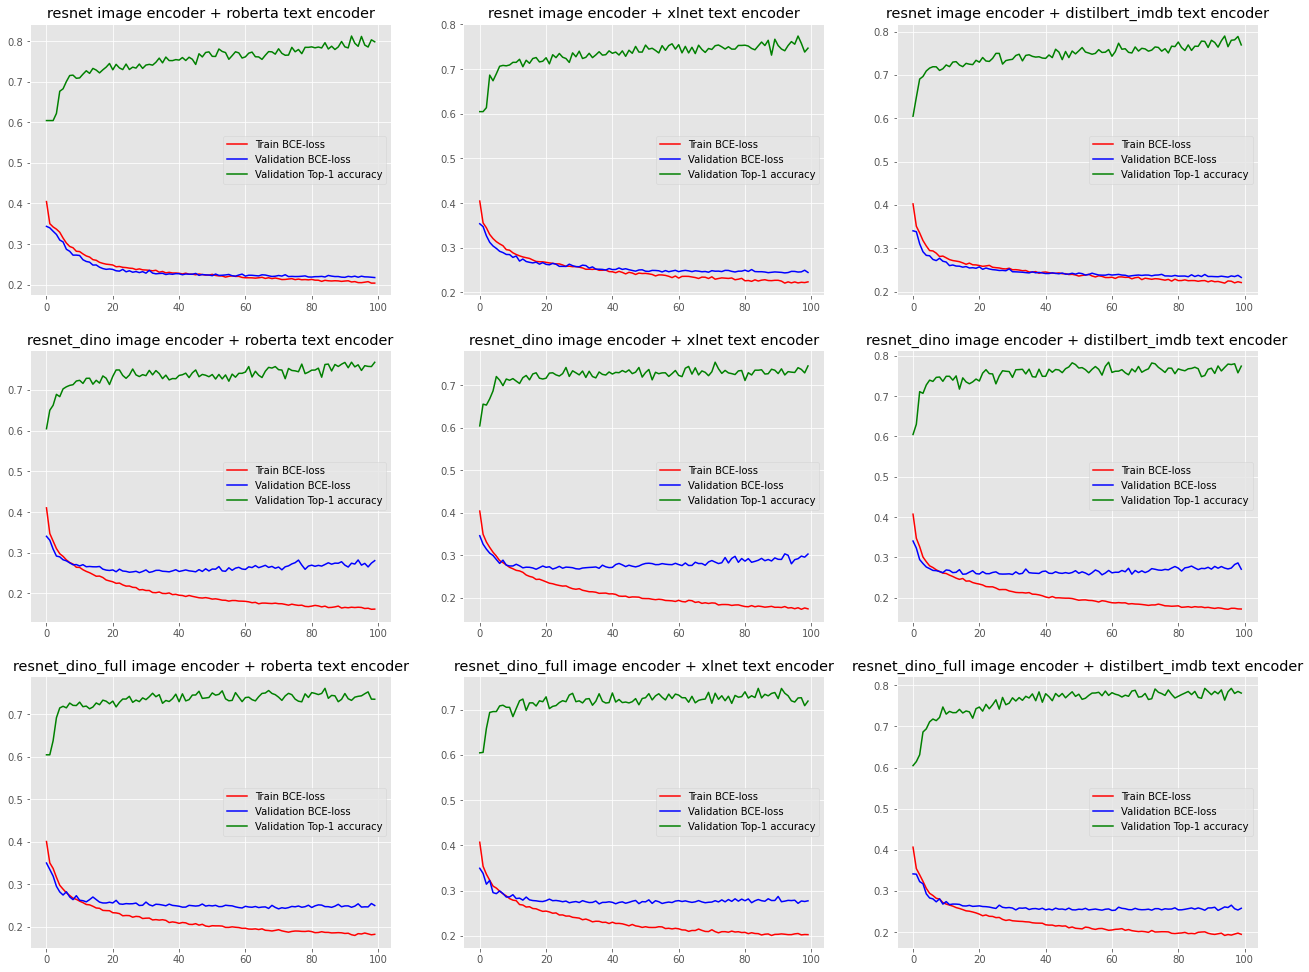

In [ ]:
plt.rcParams["figure.figsize"] = (22, 17)
plt.style.use('ggplot')
fig, ax = plt.subplots(3, 3)


img_name_list = []
txt_name_list = []
train_loss_list = []
val_loss_list = []
val_acc_list = []


for idx in range(9):
    img_file, txt_file = df_files.iloc[idx, 0][:-4], df_files.iloc[idx, 1][19:-4]
    x, y = idx // 3, idx % 3
    ax[x, y].plot(results[idx][0], label="Train BCE-loss", color="r")
    ax[x, y].plot(results[idx][1], label="Validation BCE-loss", color="b")
    ax[x, y].plot(results[idx][2], label="Validation Top-1 accuracy", color="g")

    ax[x, y].legend()
    ax[x, y].set_title(f"{img_file} image encoder + {txt_file} text encoder")

    img_name_list.append(img_file)
    txt_name_list.append(txt_file)
    train_loss_list.append(np.min(results[idx][0]))
    val_loss_list.append(np.min(results[idx][1]))
    val_acc_list.append(np.max(results[idx][2]))

fig.savefig(os.path.join(data_path, "result2.png"), dpi=300)

In [ ]:
df_results = pd.DataFrame({"Image_encoder": img_name_list, "Text_encoder": txt_name_list, "Train_loss": train_loss_list, "Test_loss": val_loss_list, "Test_accuracy": val_acc_list})
df_results

,Image_encoder,Text_encoder,Train_loss,Test_loss,Test_accuracy
0,resnet,roberta,0.203523,0.217274,0.813151
1,resnet,xlnet,0.220546,0.243406,0.773872
2,resnet,distilbert_imdb,0.219409,0.232500,0.789714
3,resnet_dino,roberta,0.161230,0.251196,0.768012
4,resnet_dino,xlnet,0.172963,0.267204,0.754557
5,resnet_dino,distilbert_imdb,0.171408,0.256744,0.783854
6,resnet_dino_full,roberta,0.179248,0.241871,0.761068
7,resnet_dino_full,xlnet,0.200666,0.270485,0.747179
8,resnet_dino_full,distilbert_imdb,0.191811,0.252654,0.792426
